In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/
%pwd

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


'/content/drive/MyDrive/Colab Notebooks'

In [2]:
%matplotlib inline
!pip install colab-env -qU
import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint, uniform
import xgboost as xgb
import utils
import seaborn as sn

In [3]:
tracks = utils.load('Data/fma_metadata/tracks.csv')
genres = utils.load('Data/fma_metadata/genres.csv')
features = utils.load('Data/fma_metadata/features.csv')
subset = tracks.index[tracks['set', 'subset'] <= 'small']
tracks = tracks.loc[subset]
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

6400 training examples, 800 validation examples, 800 testing examples


Splitting the data into training, testing and validation sets. Encoding the y's to integers and scaling the input data.

In [5]:
enc = LabelEncoder()
labels = tracks['track', 'genre_top']
# Split in training, validation and testing sets.
y_train = enc.fit_transform(labels[train])
y_val = enc.transform(labels[val])
y_test = enc.transform(labels[test])
X_train = features.loc[train, 'mfcc'].to_numpy()
X_val = features.loc[val, 'mfcc'].to_numpy()
X_test = features.loc[test, 'mfcc'].to_numpy()
# Standardize features by removing the mean and scaling to unit variance.
scaler = sklearn.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_val)
scaler.transform(X_test)
X_train_not_shuffled = X_train
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

In [6]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape #Sanity check

((6400, 140), (800, 140), (800, 140), (6400,), (800,), (800,))

Here is the SVC baseline model. No input parameters were changed and we get a test accuracy of 46.38\%.

Test accuracy: 46.38% 



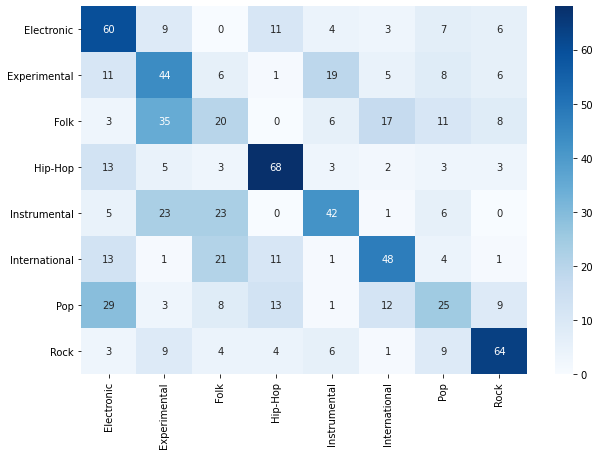

In [7]:
# SVC as a baseline model
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Test accuracy: {:.2%} \n'.format(score))
C_SVC = confusion_matrix(y_true=y_test, y_pred=clf.predict(X_test))
c_svc = pd.DataFrame(C_SVC, index = enc.classes_,columns=enc.classes_)
plt.figure(figsize=(10,7))
sn.heatmap(c_svc,annot=True,cmap='Blues',fmt='g')
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('confusion_matrix_svc.eps', format = 'eps')
plt.show()

In [60]:
#All data used for randomized CV search
X = features.loc[small, 'mfcc']
y = tracks.loc[small, ('track', 'genre_top')]

scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X)

enc = LabelEncoder()
labels = tracks['track','genre_top']
enc.fit_transform(tracks)

X, y = skl.utils.shuffle(X, y, random_state=42)
X.shape, y.shape

((8000, 140), (8000,))

Randomized CV search for hyperparameters in two stages.

In [56]:
params = {
    'learning_rate': uniform(0.05,0.3),
    'max_depth': randint(2,6),
    'n_estimators': randint(100,150),
     'gamma': uniform(0,1)
}
mdl = xgb.XGBClassifier(tree_method='gpu_hist')
srch = RandomizedSearchCV(mdl,param_distributions=params,n_iter = 50,cv=5,random_state=42)
srch.fit(X,y)
best_params = srch.best_params_
print('Mean cross validation accuracy of best classifier for this search: {:.2%}'.format(srch.best_score_))
print('Best hyper parameters according to randomized CV search: \n', best_params)

Mean cross validation accuracy of best classifier for this search: 56.38%
Best hyper parameters according to randomized CV search: 
 {'gamma': 0.05808361216819946, 'learning_rate': 0.3098528437324805, 'max_depth': 5, 'n_estimators': 139}


In [57]:
del params
params = {
    'min_child_weight': uniform(0.5,4),
    'colsample_bytree': uniform(0.5,0.5),
    'sub_samples': uniform(0.4,1)
}
mdl = xgb.XGBClassifier(tree_method='gpu_hist', learning_rate=best_params['learning_rate'],
                        max_depth = best_params['max_depth'], n_estimators = best_params['n_estimators'],
                        gamma=best_params['gamma'])
srch = RandomizedSearchCV(mdl,param_distributions=params,n_iter=50,cv=5,random_state=0)
srch.fit(X,y)
best_params.update(srch.best_params_)
print('Mean cross validation accuracy of best classifier for this search: {:.2%}'.format(srch.best_score_))
print('Best hyper parameters according to randomized CV search: \n', srch.best_params_)

Mean cross validation accuracy of best classifier for this search: 56.26%
Best hyper parameters according to randomized CV search: 
 {'colsample_bytree': 0.6592844762256618, 'min_child_weight': 3.1696415198547268, 'sub_samples': 0.5317978624043922}


In [62]:
mdl = xgb.XGBClassifier(tree_method='gpu_hist',learning_rate=best_params['learning_rate'],
                        max_depth = best_params['max_depth'], n_estimators = best_params['n_estimators'],
                        colsample_bytree=best_params['colsample_bytree'], min_child_weight=best_params['min_child_weight'],
                        sub_samples=best_params['sub_samples'],gamma = best_params['gamma'])
mdl.fit(X_train,y_train)
y_pred_train = mdl.predict(X_train)
y_pred_test = mdl.predict(X_test)
train_acc = accuracy_score(y_train,y_pred_train)
test_acc = accuracy_score(y_test,y_pred_test)
print('Train accuracy: {:.2%} Test accuracy: {:.2%} '.format(train_acc,test_acc))

Train accuracy: 99.98% Test accuracy: 42.75% 


As we can see the randomized search did well on the mean validation accuracy but did very poorly on the test set. Therefor we do anaother manual grid search for hyper-parameters in search of better results.

In [7]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
#Manual grid search for best hyperparameters
learning_rates = [0.2, 0.25]
min_child_weights = [1, 1.5]
max_depths = [4, 6]
col_samples = [0.5, 1]
n_estimators = [100, 150]
best_params = {}
best_val_acc = 0
i = 1
n = 2*2*2*2*2
for learning_rate in learning_rates:
  for max_depth in max_depths:
    for col_sample in col_samples:
      for n_est in n_estimators:
        for min_child_weight in min_child_weights:
          mdl = xgb.XGBClassifier(learning_rate=learning_rate,
                                max_depth = max_depth, colsample_bytree=col_sample,
                                n_estimators = n_est,min_child_weight=min_child_weight)
          mdl.fit(X_train,y_train)
          y_pred_train = mdl.predict(X_train)
          y_pred_val = mdl.predict(X_val)
          train_acc = accuracy_score(y_train,y_pred_train)
          val_acc = accuracy_score(y_val,y_pred_val)
          if(val_acc>best_val_acc):
            best_val_acc = val_acc
            best_params['learning_rates'] = learning_rate
            best_params['colsample_bytree'] = col_sample
            best_params['max_depth'] = max_depth
            best_params['n_estimators'] = n_est
            best_params['min_child_weight'] = min_child_weight
          print('Iteration {} out of {}'.format(i,n))
          print('Train accuracy: {:.2%} \nVal accuracy: {:.2%} \n'.format(train_acc,val_acc))
          i = i+1

print('Best parameters: \n', best_params)
print('Best validation accuracy: {:.2%}'.format(best_val_acc))

Iteration 1 out of 32
Train accuracy: 95.45% 
Val accuracy: 51.88% 

Iteration 2 out of 32
Train accuracy: 95.06% 
Val accuracy: 51.62% 

Iteration 3 out of 32
Train accuracy: 99.23% 
Val accuracy: 51.38% 

Iteration 4 out of 32
Train accuracy: 99.11% 
Val accuracy: 52.00% 

Iteration 5 out of 32
Train accuracy: 96.22% 
Val accuracy: 52.25% 

Iteration 6 out of 32
Train accuracy: 96.17% 
Val accuracy: 52.25% 

Iteration 7 out of 32
Train accuracy: 99.44% 
Val accuracy: 52.25% 

Iteration 8 out of 32
Train accuracy: 99.55% 
Val accuracy: 52.62% 

Iteration 9 out of 32
Train accuracy: 99.98% 
Val accuracy: 52.25% 

Iteration 10 out of 32
Train accuracy: 99.98% 
Val accuracy: 53.50% 

Iteration 11 out of 32
Train accuracy: 99.98% 
Val accuracy: 52.25% 

Iteration 12 out of 32
Train accuracy: 99.98% 
Val accuracy: 53.50% 

Iteration 13 out of 32
Train accuracy: 99.98% 
Val accuracy: 52.38% 

Iteration 14 out of 32
Train accuracy: 99.98% 
Val accuracy: 53.50% 

Iteration 15 out of 32
Train 

Test accuracy: 43.50%


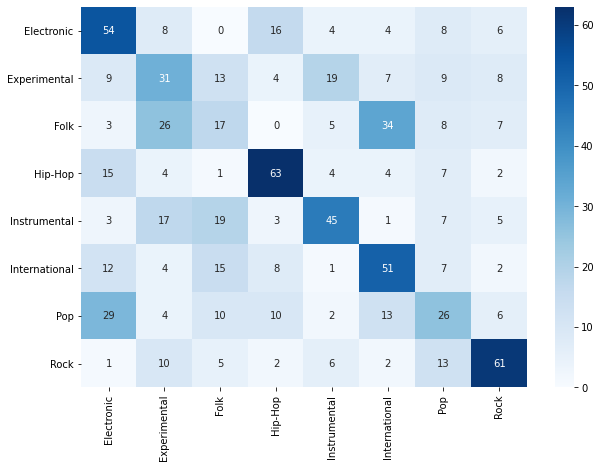

In [8]:
mdl = xgb.XGBClassifier(learning_rate=best_params['learning_rates'],
                                max_depth = best_params['max_depth'], colsample_bytree=best_params['colsample_bytree'],
                                n_estimators = best_params['n_estimators'],
                                min_child_weight=best_params['min_child_weight'])
mdl.fit(X_train,y_train)
y_pred_test = mdl.predict(X_test)
test_acc = accuracy_score(y_test,y_pred_test)
print('Test accuracy: {:.2%}'.format(test_acc))
C_XGB = confusion_matrix(y_test,y_pred_test)
c_xgb = pd.DataFrame(C_XGB, index = enc.classes_,columns=enc.classes_)
plt.figure(figsize=(10,7))
sn.heatmap(c_xgb,annot=True,cmap='Blues',fmt='g')
plt.show()

As we can see the second XGBoost classifier performs better than the first one. However SVC is still the best one. The confusion matrixes for XGB and SVC are similar.